# Employee Attrition Modeling

This project is a demonstration in predictive modeling for employee attrition using machine learning. The dataset used for this project is a fictitious dataset originally found on Kaggle but the source is no longer available.

This notebook will walkthrough the end-to-end process of exploring a dataset, preprocessing features, building models, and evaluating models. The libraries used in this project are Pandas, Numpy, Plotly, Seaborn, Matplotlib, Scikit-Learn, and Scikitplot.

<b>Note: </b>If viewing this directly on Github, you will not be able to see the Plotly graphs due to the embedded JavaScript and HTML that will not output on Github's static render. For full render viewing please enter the Github URL of this notebook into the following site: https://nbviewer.jupyter.org. If the link does not work please download the HTML file from this repo, or clone the full repo if you wish to run the notebook locally.

# Imports

In [1]:
# Data wrangling and visualization
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Pre-processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
import scikitplot as skplt

In [2]:
# Change display config options
pd.set_option('max_columns', None)

In [3]:
# Load data
df = pd.read_excel('data/employee_attrition.xlsx')

# Exploratory Data Analysis

In [4]:
# Preview of the data
df.head()

emp_id  satisfaction_level  last_evaluation  number_project  \
0    2001                0.58             0.74               4   
1    2002                0.82             0.67               2   
2    2003                0.45             0.69               5   
3    2004                0.78             0.82               5   
4    2005                0.49             0.60               3   

   average_monthly_hours  time_spend_company  work_accident  \
0                    215                   3              0   
1                    202                   3              0   
2                    193                   3              0   
3                    247                   3              0   
4                    214                   2              0   

   promotion_last_5years   dept salary  attrition  
0                      0  sales    low          0  
1                      0  sales    low          0  
2                      0  sales    low          0  
3                      0  sales    low          0  
4                      0  sales    low          0

In [5]:
# Check dimensions
df.shape

(14999, 11)

In [6]:
# Check for missing data
df.isna().sum()

emp_id                   0
satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
time_spend_company       0
work_accident            0
promotion_last_5years    0
dept                     0
salary                   0
attrition                0
dtype: int64

In [7]:
# Check data types
df.dtypes

emp_id                     int64
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_monthly_hours      int64
time_spend_company         int64
work_accident              int64
promotion_last_5years      int64
dept                      object
salary                    object
attrition                  int64
dtype: object

In [8]:
# Create function to return value range of numeric field
def value_range(c):
    print(c, 'value range: [ min:', df[c].min(), '|',  'max:', df[c].max(), ']')

In [9]:
# Loop to return value range of all numeric features
for c in df:
    if df[c].dtype != 'object':
        value_range(c)
    else:
        pass

emp_id value range: [ min: 1 | max: 14999 ]
satisfaction_level value range: [ min: 0.09 | max: 1.0 ]
last_evaluation value range: [ min: 0.36 | max: 1.0 ]
number_project value range: [ min: 2 | max: 7 ]
average_monthly_hours value range: [ min: 96 | max: 310 ]
time_spend_company value range: [ min: 2 | max: 10 ]
work_accident value range: [ min: 0 | max: 1 ]
promotion_last_5years value range: [ min: 0 | max: 1 ]
attrition value range: [ min: 0 | max: 1 ]


In [10]:
# See all unique values for the categorical features
for c in df:
    if df[c].dtype == 'object':
        print(c, 'unique values: ', '\n', df[c].unique(), '\n')
    else:
        pass

dept unique values:  
 ['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'RandD' 'marketing'] 

salary unique values:  
 ['low' 'medium' 'high'] 



In [11]:
# For consistency, make all department values the same case (lowercase)
df['dept'] = df['dept'].str.lower()
df['dept'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'it', 'product_mng', 'randd', 'marketing'], dtype=object)

In [12]:
# Split the dataset according to employees who are still with the company and those who have left
active = df[df['attrition']==0]
leavers = df[df['attrition']==1]

In [13]:
# Check how many employees are active vs those who left
print('Number of active employees: ', active.shape[0])
print('Number of leavers: ', leavers.shape[0])

Number of active employees:  11428
Number of leavers:  3571


In [14]:
# Percentage of leavers
print('Percentage of leavers: ', '%.2f%%' % ((leavers.shape[0] / active.shape[0])*100))

Percentage of leavers:  31.25%


In [15]:
# Look at mean and standard deviation of all features for active employees
active.drop(columns=['emp_id']).describe().loc[['mean','std']]

satisfaction_level  last_evaluation  number_project  \
mean            0.666810         0.715473        3.786664   
std             0.217104         0.162005        0.979884   

      average_monthly_hours  time_spend_company  work_accident  \
mean             199.060203            3.380032       0.175009   
std               45.682731            1.562348       0.379991   

      promotion_last_5years  attrition  
mean               0.026251        0.0  
std                0.159889        0.0

In [16]:
# Look at mean and standard deviation of all features for leavers
leavers.drop(columns=['emp_id']).describe().loc[['mean','std']]

satisfaction_level  last_evaluation  number_project  \
mean            0.440098         0.718113        3.855503   
std             0.263933         0.197673        1.818165   

      average_monthly_hours  time_spend_company  work_accident  \
mean             207.419210            3.876505       0.047326   
std               61.202825            0.977698       0.212364   

      promotion_last_5years  attrition  
mean               0.005321        1.0  
std                0.072759        0.0

Key observations:
<li>Satisfaction levels for leavers are lower compared to active employees</li>
<li>Evaluation scores only differ marginally between the two groups</li>
<li>Leavers were far less likely to have received a promotion in the last 5 years</li>
<li>Leavers worked more hours</li>
<li>Leavers have spent more time with the company</li>

<br>All of these observations make sense as performance did not differ significantly yet those who left the organization received far less promotions and worked longer hours on average than those who are still with the organization, and also have been with the company longer. Naturally it is easy to imagine how this would contribute to lower satisfaction levels. From this we can infer that satisfaction level could be a very useful attribute for predicting employee churn, as it can generally be said that dissatisfied employees are more likely to leave an organization than satisfied employees. A more in-depth analysis is needed but first let's take a high level analysis on all of the variables to understand their distribution.

There are two categorical variables in our data: department and salary. We can look at how many people are leaving as well as the attrition percentage from each department and salary level.

In [17]:
# Create dataframe that derives the count and percentage of attrition within each department
df_attrition_by_dept = df.groupby(['dept', 'attrition']).size().reset_index().rename(columns={0:'count'})
df_attrition_by_dept['pct'] = df.groupby(['dept', 'attrition']).size().groupby(level=0).apply(lambda x: (x / x.sum()) * 100).values.round(2)

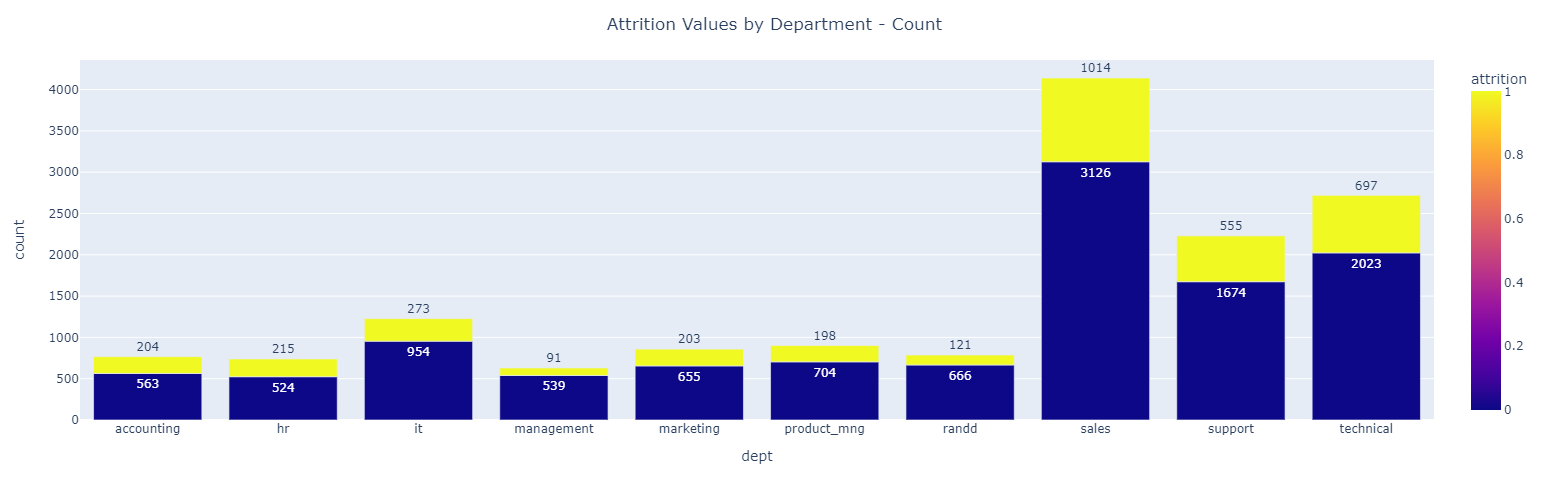

In [18]:
# Plot attrition values by department - count
fig_attrition_by_dept_count = px.bar(df_attrition_by_dept, x='dept', y='count', text='count', color='attrition', barmode='stack', width=900, height=500)
fig_attrition_by_dept_count.update_layout(title='Attrition Values by Department - Count', title_x=0.5)
fig_attrition_by_dept_count.update_traces(textposition='outside', cliponaxis=False)

We can see that the Sales, Technical, and Support departments show the highest number of leavers by far. However, it is important to also note that these departments show significantly more active employees than all other departments as well. As such, these are the three largest departments in the organization so they will always show a higher number of leavers due to their sheer size. However, we can look at the attrition percentage in each department to see if people are leaving these departments at a relatively greater rate compared to the other departments.

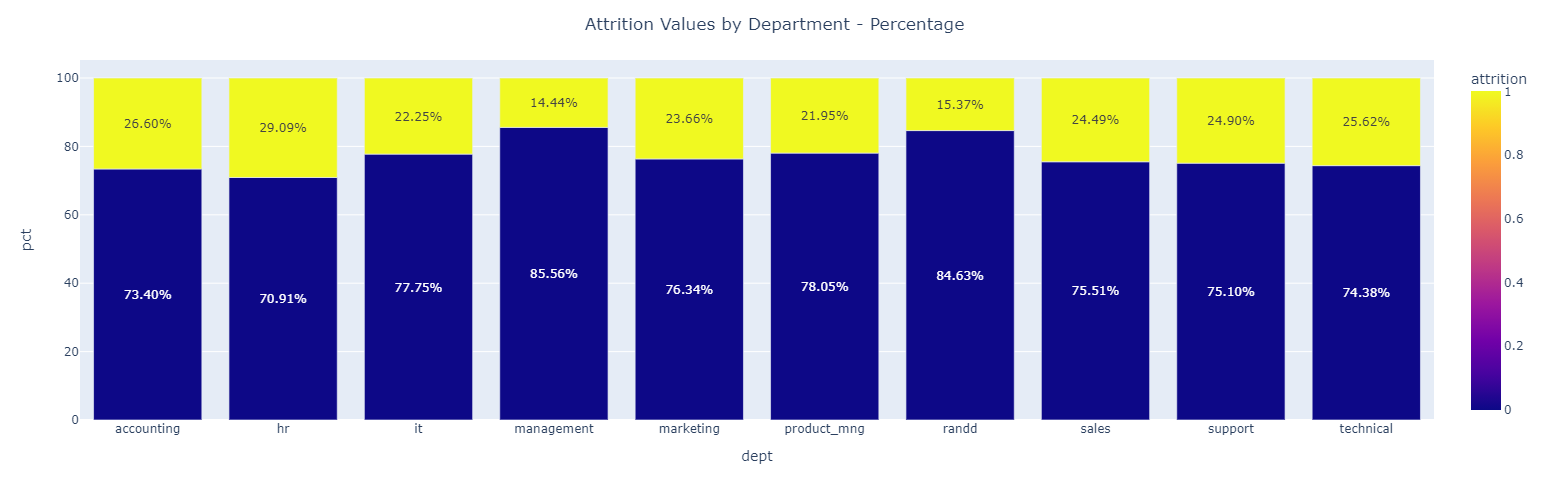

In [19]:
# Plot attrition values by department - percentage
fig_attrition_by_dept_pct = px.bar(df_attrition_by_dept, x='dept', y='pct', text='pct', color='attrition', barmode='stack', width=900, height=500)
fig_attrition_by_dept_pct.update_layout(title='Attrition Values by Department - Percentage', title_x=0.5)
fig_attrition_by_dept_pct.update_traces(textposition='inside', insidetextanchor='middle', texttemplate='%{text:.2f}%')

We can see the the relative attrition percentage of the Sales, Technical, and Support departments are not significantly higher than all of the other departments. In fact all of the departments with the exception of Management and R&D are fairly comparable, indicating that no one department is suffering from a particularly higher attrition (which is an observation we might see if some departments were problematic, such as having a toxic culture or leadership within the department that is causing a high attrition).

Next we will look at the same with regards to salary level.

In [20]:
# Create dataframe that derives the count and percentage of attrition within salary levels
df_attrition_by_salary = df.groupby(['salary', 'attrition']).size().reset_index().rename(columns={0:'count'})
df_attrition_by_salary['pct'] = df.groupby(['salary', 'attrition']).size().groupby(level=0).apply(lambda x: (x / x.sum()) * 100).values.round(2)

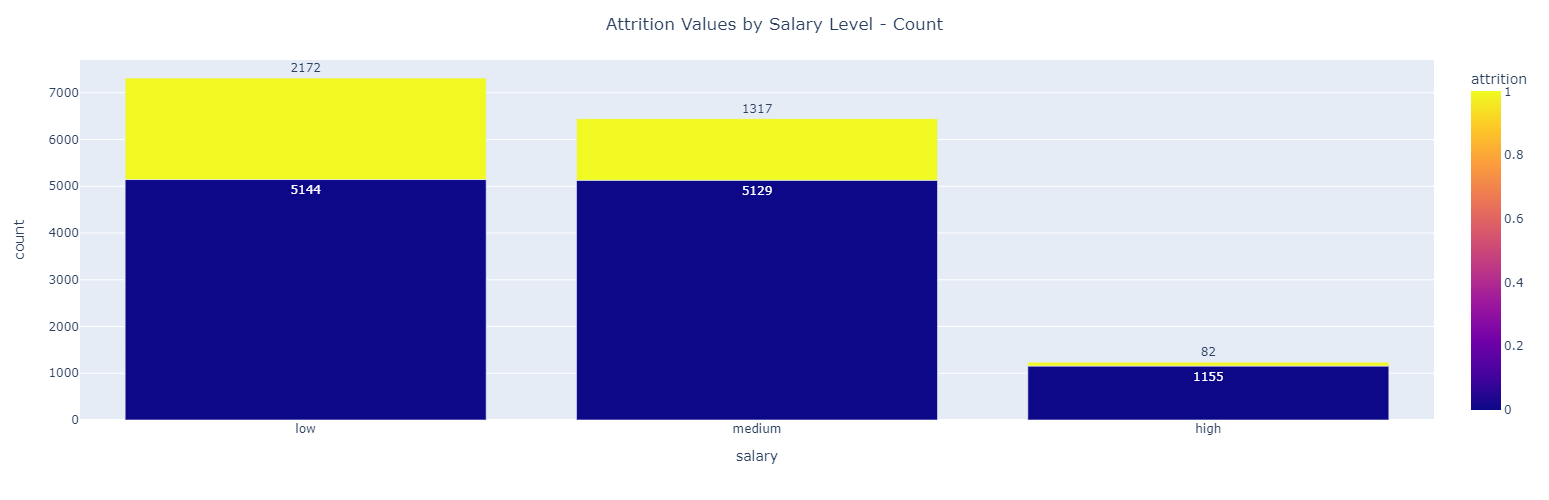

In [21]:
# Plot attrition values by department - count
fig_attrition_by_salary_count = px.bar(df_attrition_by_salary, x='salary', y='count', text='count', color='attrition', barmode='stack', width=900, height=500)
fig_attrition_by_salary_count.update_layout(title='Attrition Values by Salary Level - Count', title_x=0.5)
fig_attrition_by_salary_count.update_traces(textposition='outside', cliponaxis=False )
fig_attrition_by_salary_count.update_xaxes(categoryorder='array', categoryarray=['low','medium','high'])

We see the most leavers in the low salary level and the least in the high salary level, which is an expected observation. Let's also look at the relative attrition percentages within each level get a sense of proportion.

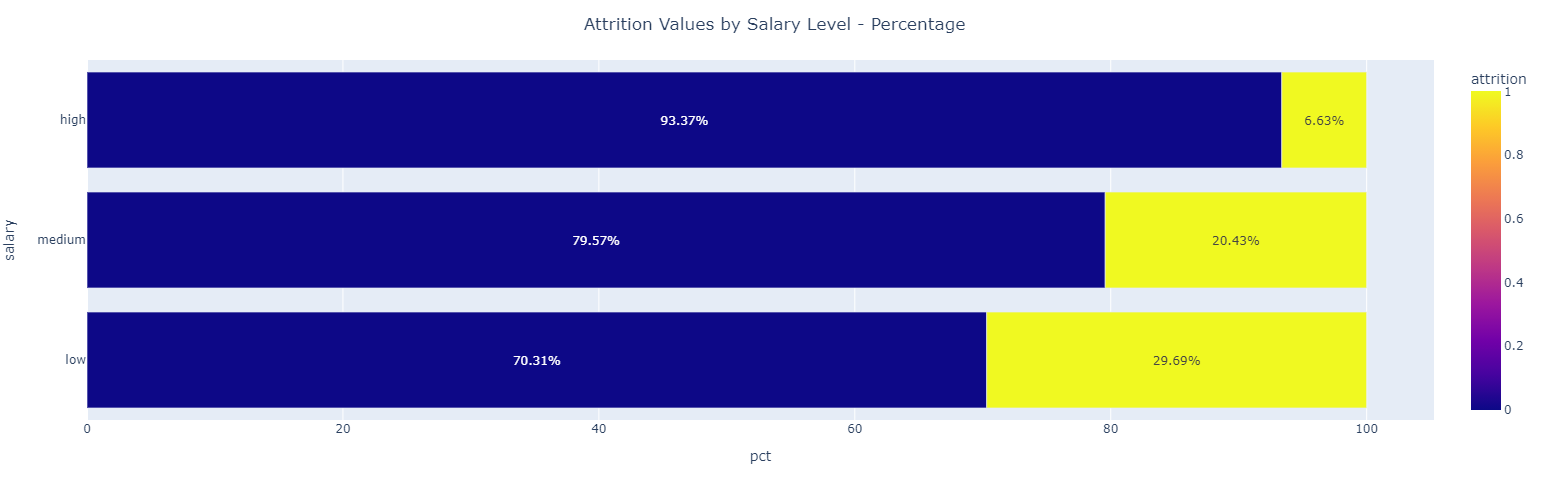

In [22]:
# Plot attrition values by department - percentage
fig_attrition_by_salary_pct = px.bar(df_attrition_by_salary, x='pct', y='salary', text='pct', color='attrition', barmode='stack', width=975, height=500)
fig_attrition_by_salary_pct.update_layout(title='Attrition Values by Salary Level - Percentage', title_x=0.5)
fig_attrition_by_salary_pct.update_traces(textposition='inside', insidetextanchor='middle', texttemplate='%{text:.2f}%')
fig_attrition_by_salary_pct.update_yaxes(categoryorder='array', categoryarray=['low','medium','high'])

We can dig a little deeper and look at the attrition rate within each department, this time focusing only on leavers.

In [23]:
# Create dataframe that derives the count and percentage of attrition in each salary level per department
df_attrition_by_dept_salary_leavers = leavers.groupby(['dept', 'salary']).size().reset_index().rename(columns={0:'count'})
df_attrition_by_dept_salary_leavers['pct'] = leavers.groupby(['dept', 'salary']).size().groupby(level=0).apply(lambda x: (x / x.sum()) * 100).values.round(2)

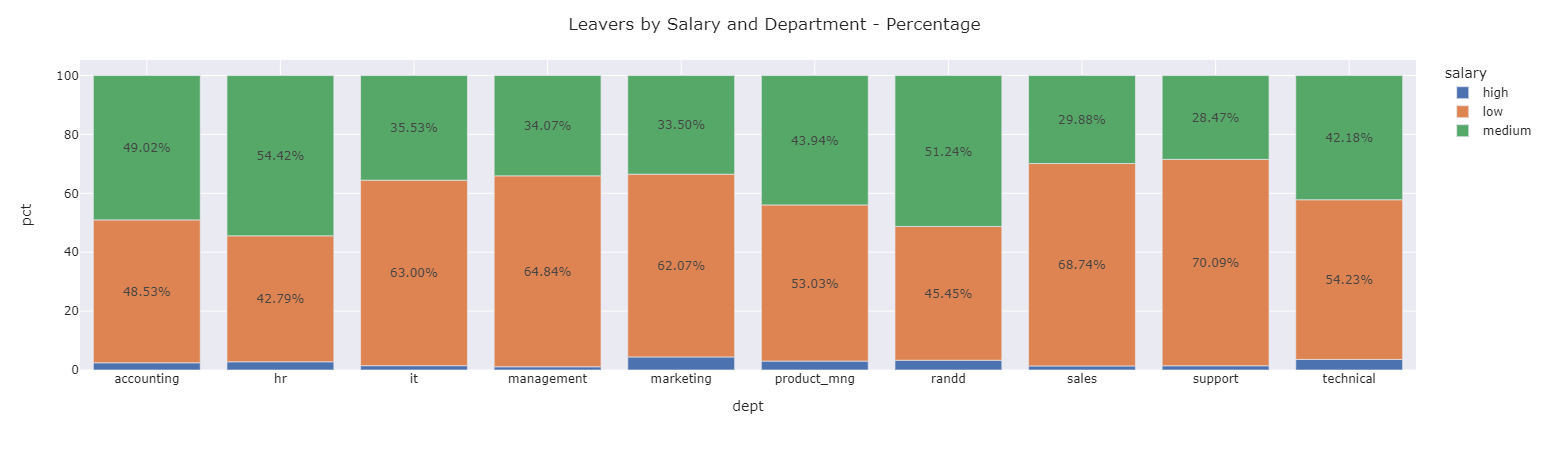

In [24]:
# Plot leaver attrition rate by salary and department
fig_attrition_by_dept_salary_leavers = px.bar(df_attrition_by_dept_salary_leavers, x='dept', y='pct', text='pct', color='salary', template='seaborn', width=1200, height=450)
fig_attrition_by_dept_salary_leavers.update_layout(title='Leavers by Salary and Department - Percentage', uniformtext_minsize=8, uniformtext_mode='hide')
fig_attrition_by_dept_salary_leavers.update_traces(textposition='inside', insidetextanchor='middle', texttemplate='%{text:.2f}%')

We can see from this that it is not always the case that higher salary levels show a higher attrition than lower levels, such as that for Accounting, HR, and R&D where there are more leavers in the medium salary level. For leavers in the high salary level, since the values are so low across all departments, Plotly cannot display the value labels large enough to be readable so let us look at the values in the dataframe directly.

In [25]:
# Subset dataframe for high salary level sorted descending by pct
df_attrition_by_dept_salary_leavers[['dept','pct']][df_attrition_by_dept_salary_leavers['salary']=='high'].sort_values(by='pct', ascending=False).reset_index(drop=True)

dept   pct
0    marketing  4.43
1    technical  3.59
2        randd  3.31
3  product_mng  3.03
4           hr  2.79
5   accounting  2.45
6           it  1.47
7      support  1.44
8        sales  1.38
9   management  1.10

Now let's look at the distributions of the numerical features to get a sense of where the bulk of data sits, if there is any skewness, etc.

In [26]:
df.dtypes[df.dtypes != 'object']

emp_id                     int64
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_monthly_hours      int64
time_spend_company         int64
work_accident              int64
promotion_last_5years      int64
attrition                  int64
dtype: object

In [27]:
# Function to create subplots to show both a boxplot and histogram
def plot_feature_distribution(c):
    # Build plot space
    fig, (ax_box, ax_hist) = plt.subplots(nrows=2, ncols=2, sharex=True, gridspec_kw={'height_ratios':[0.20, 0.80]}, figsize=(15,5))
    
    # Instantiate boxplot and histplot objects
    sns.boxplot(data=active, x=c, ax=ax_box[0])
    sns.histplot(data=active, x=c, kde=True, ax=ax_hist[0])
    sns.boxplot(data=leavers, x=c, ax=ax_box[1])
    sns.histplot(data=leavers, x=c, kde=True, ax=ax_hist[1])
    
    # Set subplot and figure titles, remove redundant x-axis label on boxplot
    ax_box[0].set_title('Active Employees', fontsize=12)
    ax_box[0].set(xlabel=None)
    ax_box[1].set_title('Leavers', fontsize=12)
    ax_box[1].set(xlabel=None)
    fig.suptitle('Feature Distribution: {}'.format(c), fontsize=16)

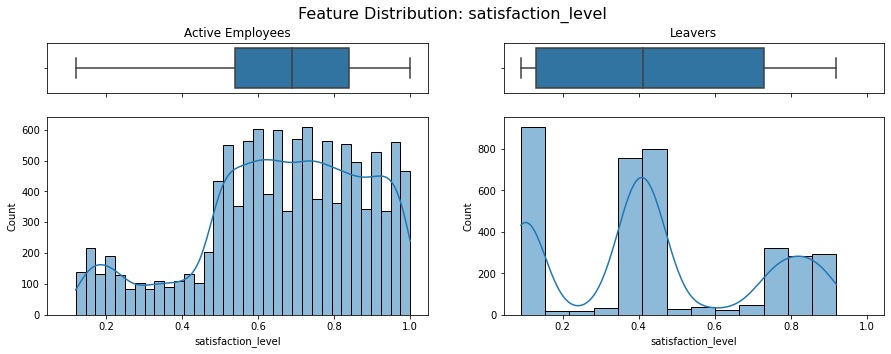

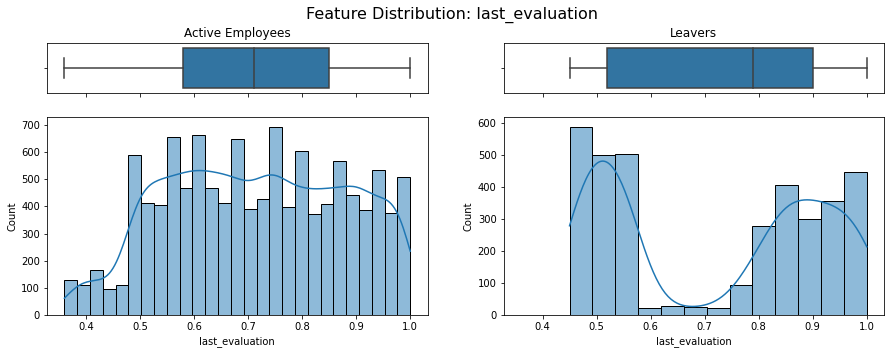

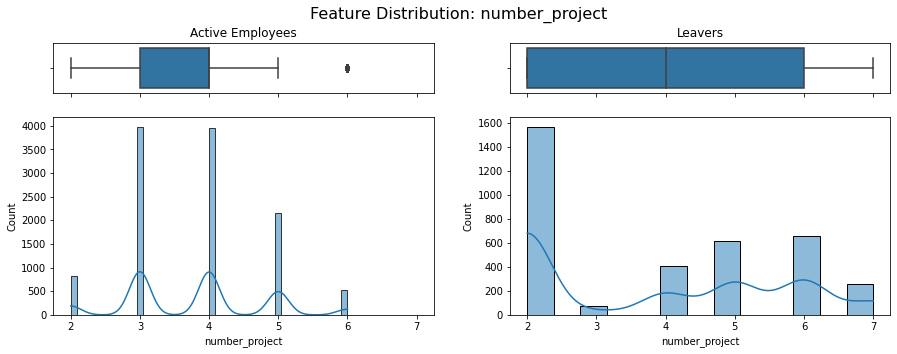

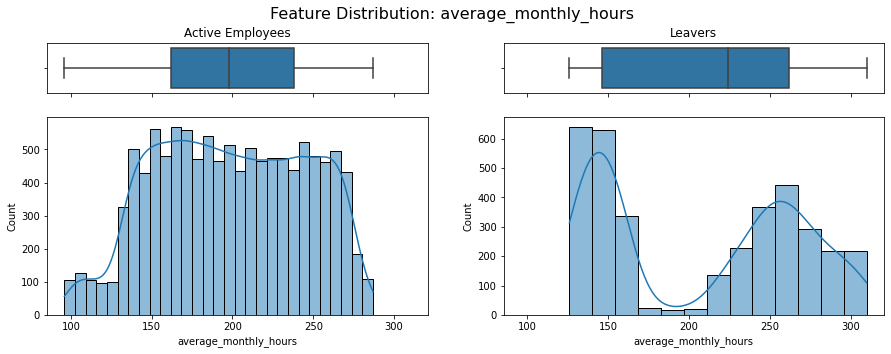

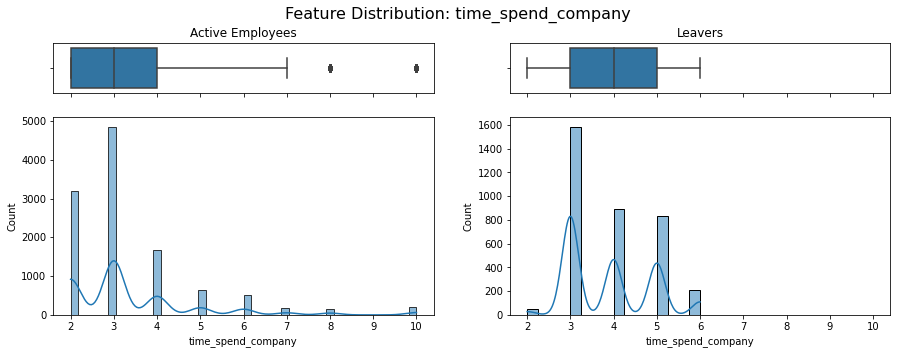

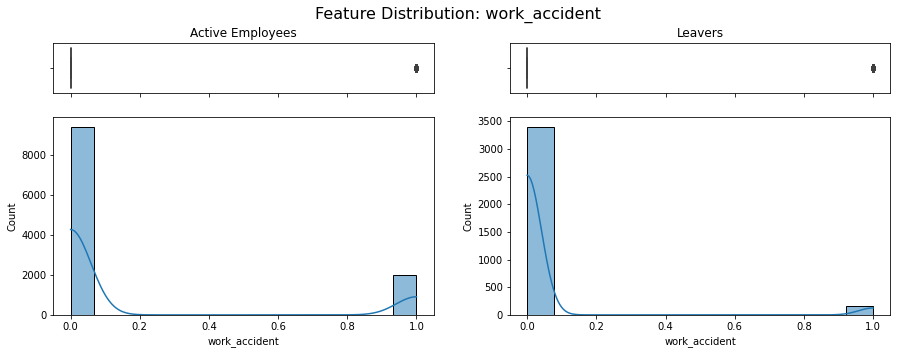

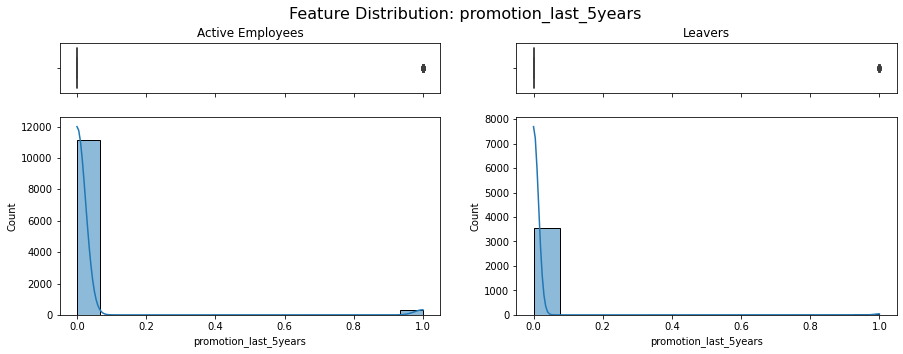

In [28]:
# Loop to plot feature distributions for all numeric features
# Drop emp_id because it is a unique identifier and not a true quantatitive value
# Drop attrition because each column of the subplot looks at active and leavers separately, thus will have no variance within each subplot
for c in df.drop(columns=['emp_id','attrition']).columns[df.drop(columns=['emp_id','attrition']).dtypes != 'object']:
    plot_feature_distribution(c)

Additional observations from the above plots:
When we looked at the core statistics for the features, we saw that satisfaction scores were lower amongst leavers than active employees but that the last evaluation scores did not differ significantly between the groups. In the histogram and boxplot above for the last evaluation score, we see that the distribution is tail-skewed both in the lower and upper boundary, which is an interesting observation. It also makes sense because poor performers are likely to get let go or resign due to lack of fit, and high performers who are not satisfied tend to leave the organization more than their satisfied counterparts especially since they have been with the company longer, work longer hours, and are much less likely to receive promotions in the last 5 years.

With this, let's explore the data further to see if we can cluster the leavers according to their satisfaction level and last evaluation scores.

Text(0.5, 1.0, 'Satisfaction Level and Last Evaluation')

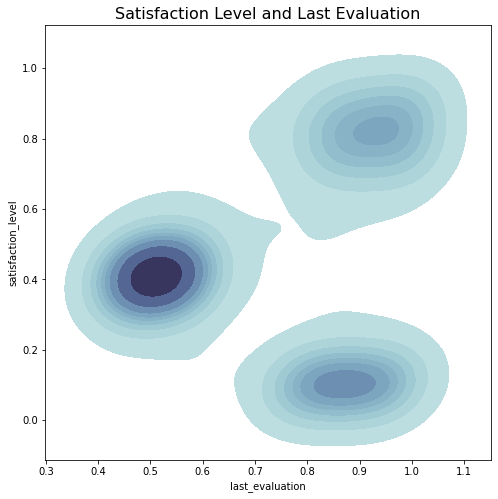

In [29]:
# Create KDE plot to cluster leavers by satisfaction level and last evaluation scores
plt.figure(figsize=(8,8))
sns.kdeplot(data=leavers, x='last_evaluation', y='satisfaction_level', cmap='ch:start=.2, rot=-.3', shade=True)
plt.title('Satisfaction Level and Last Evaluation', fontsize=16)

The KDE plot reveals 3 clusters when looking at satisfaction level and last evaluation:
<li>High performers who are highly satisfied on the job</li>
<li>High performers who are dissatisfied on the job</li>
<li>Low perfomers who are somewhat dissatisfied on the job</li>

<br>The strongest density is amongst the group of low performers who are somewhat dissatisfied on the job. This is the group of employees who are both not productive nor are they engaged, and as such the withdrawal of these employees is ultimately a good thing.

The concern for the organization is for the high performers who are leaving, regardless of whether they are dissatisfied or not. While it is expected to see high performers who are dissatisfied leave an organization, an organization should strive to understand why those employees were dissatisfied. It is however equally important to understand why high performers who are satisfied on the job leave the organization. If they are happy on the job, it is generally not expected that they will leave. To try and get an indication of what factors could be at play here, let's take a look at a correlation heatmap to see if there are any correlations that we should focus on.

<AxesSubplot:>

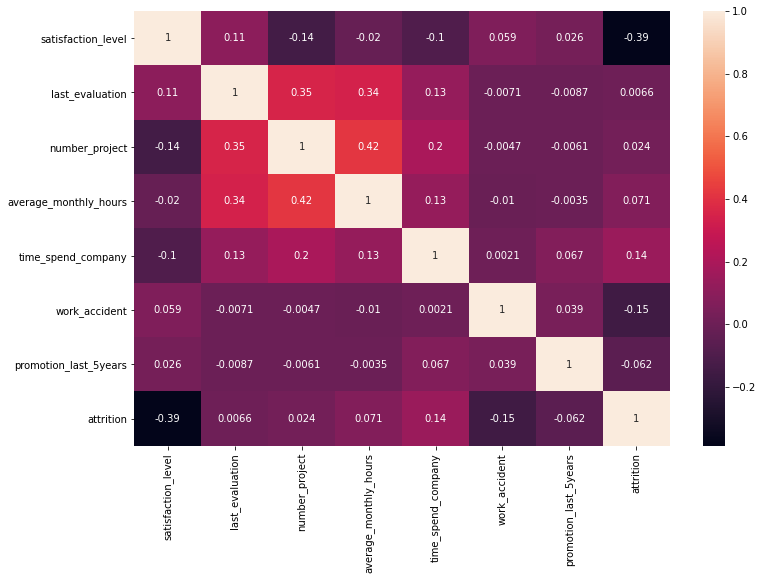

In [30]:
# Build heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.drop(columns='emp_id').corr(), annot=True)

The heatmap shows us a few appreciable correlations and observations:
<li>Satisfaction level has a negative correlation with attrition which makes sense, as higher satisfaction generally means lower risk of attrition</li>
<li>Last evaluation score is positively correlated with number of projects and average monthly hours, so it could be that the more time you spend at work and the higher number of projects you work on partially leads to a more positive evaluation from the fact that you at least appear to be working hard</li>
<li>Number of projects and average monthly hours are positively correlated which makes sense since the more projects you have, the more work you have, and thus the longer you must spend at work in a given month. While these may seem like somewhat redundant features, it is not necessarily always the case - it could be that an employee is only on 1 or 0 projects but is spending a lot of overtime at work, in which case it could be an indicator of workplace inefficiencies</li>

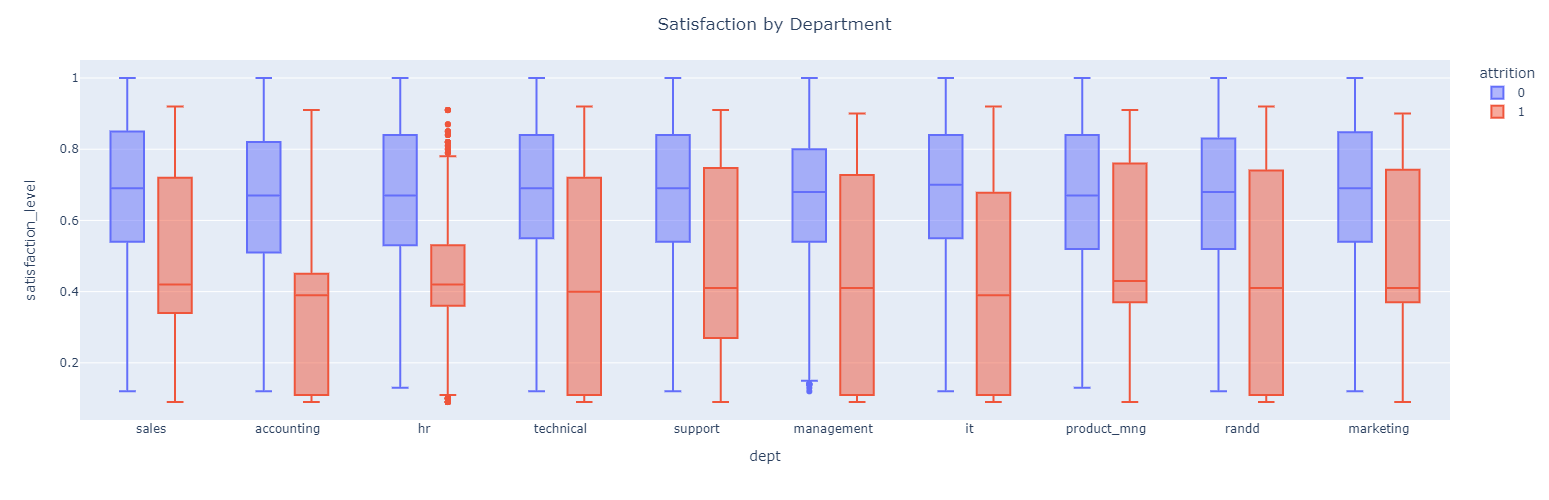

In [31]:
# Since satisfaction level is problably one of the most important features to impact attrition, let's explore this first
fig_satisfaction_by_dept = px.box(df, x='dept', y='satisfaction_level', color='attrition', width=950, height=500)
fig_satisfaction_by_dept.update_layout(title='Satisfaction by Department', title_x=0.5)

We already saw in the initial data understanding that the mean satisfaction level for active employees is higher than leavers, but this plot shows us that the IQRs across departments are very similar for active employees however we see a much greater IQR variance for leavers. So why does satisfaction vary so much amongst leavers? Let's dig further.

In [32]:
# Maybe some of these departments are overworked - let's see the median of the average monthly hours for both active employees and leavers to compare
df_median_hours_dept_leavers = leavers.groupby('dept')['average_monthly_hours'].median().reset_index().rename(columns={'average_monthly_hours':'average_monthly_hours_leavers'})
df_median_hours_dept_active = active.groupby('dept')['average_monthly_hours'].median().reset_index().rename(columns={'dept':'dept_active','average_monthly_hours':'average_monthly_hours_active'})
df_median_hours_all = pd.concat([df_median_hours_dept_leavers, df_median_hours_dept_active], axis=1)
df_median_hours_all.drop(columns='dept_active', inplace=True)
df_median_hours_all['delta'] = df_median_hours_all['average_monthly_hours_leavers'] - df_median_hours_all['average_monthly_hours_active']
df_median_hours_all.sort_values(by='delta', ascending=False, inplace=True)
df_median_hours_all.reset_index(drop=True, inplace=True)

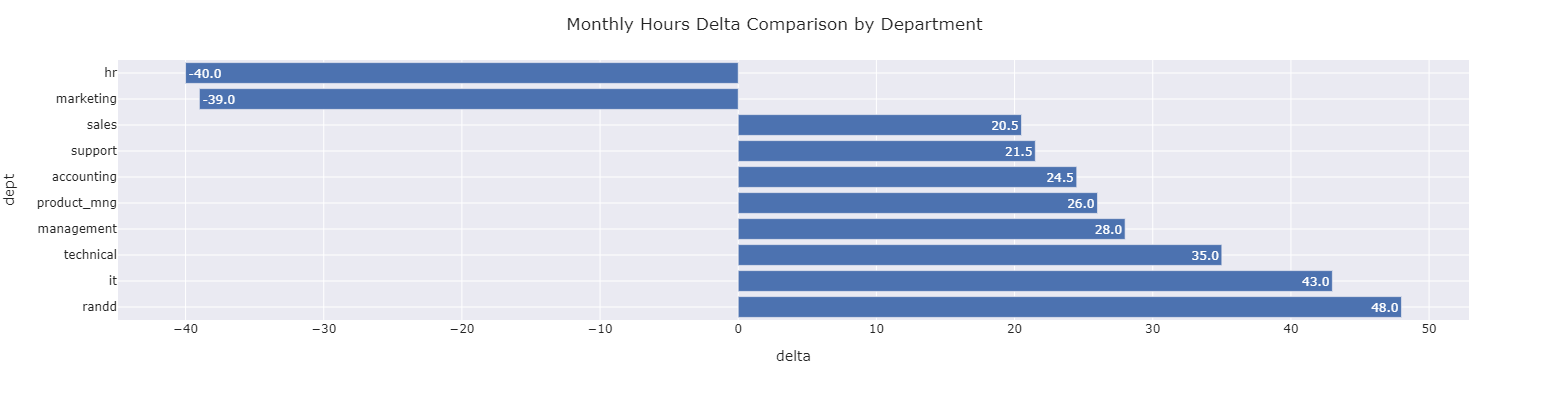

In [33]:
# Plot the difference between the median of average monthly hours by department
fig_median_hours_all = px.bar(df_median_hours_all, x='delta', y='dept', text='delta', template='seaborn', width=1050, height=400)
fig_median_hours_all.update_layout(title='Monthly Hours Delta Comparison by Department', title_x=0.5)
fig_median_hours_all.update_xaxes(categoryorder='category descending')

We can see leavers in most departments were working quite a few more hours on average a month. This could easily factor into lower satisfaction scores across the board when combined with the other observations we've seen for leavers.

So now we have a decent understanding of the factors contributing to attrition: lower satisfaction, higher average of monthly working hours, longer tenure with the company with much less likelihood of receiving a promotion in the last 5 years. 

There are two factors we did not investigate in depth: number of projects and work accident. Number of projects was shown to be correlated with average monthly working hours and by itself wouldn't necessarily be of value since in some cases employees could have a low number of projects but high average working hours. As such, this is a secondary factor that is not expected to be a primary driver. Work accident is also considered to be a secondary factor because work accidents severe enough to cause attrition would be due to reasons separate from the employee's satisfaction on the job.

Now we can move on to build some machine learning models to try and predict who will leave the organization.

# Preprocessing & Model Pipelining

We will build our preprocessing and modeling into pipelines in this section.

For preprocessing, we first need to encode the categorical variables into numerical features. There are two categorical features: dept and salary, and we will use one hot encoding to handle this for department and ordinal encoding for salary. Additionally, we will use MinMaxScaler in order to normalize the features.

First let's start with department where we will use the Scikit-Learn OneHotEncoder rather than the Pandas get_dummies method. The reasons for this choice are:

<li>Preprocessing outside of Scikit-Learn can make cross validation scores less reliable</li>
<li>OneHotEncoder does not add the encoding into dataframes, thus keeps dataframes smaller and easier to manage</li>
<li>Using get_dummies would require us to re-run it for new data that is out of sample (e.g. has new categories)</li>
<li>OneHotEncoder allows us to run gridsearch with preprocessing and modeling parameters</li>

In [34]:
# One hot encode department values to see how the array will look
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(df[['dept']])

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [35]:
# Check columns of array
ohe.categories_

[array(['accounting', 'hr', 'it', 'management', 'marketing', 'product_mng',
        'randd', 'sales', 'support', 'technical'], dtype=object)]

In [36]:
# Ordinal encode salary values to see how the array will look
oe = OrdinalEncoder()
oe.fit_transform(df[['salary']])

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [37]:
# Let's see what the salary encoded values are
# We'll create a temporary dataframe for validation by copying part of the main dataframe
df_salary_encoded_validation = df[['salary']].copy()
df_salary_encoded_validation['salary_encoded'] = oe.fit_transform(df[['salary']])

In [38]:
# See mapping of encoded values
display(df_salary_encoded_validation[df_salary_encoded_validation['salary']=='low'].head(1).reset_index(drop=True))
display(df_salary_encoded_validation[df_salary_encoded_validation['salary']=='medium'].head(1).reset_index(drop=True))
display(df_salary_encoded_validation[df_salary_encoded_validation['salary']=='high'].head(1).reset_index(drop=True))

salary  salary_encoded
0    low             1.0

salary  salary_encoded
0  medium             2.0

salary  salary_encoded
0   high             0.0

In [39]:
# Divide the data into feature and target matrices
X = df.drop(columns='attrition')
y = df['attrition']

In [40]:
# Preview feature matrix
X.head(5)

emp_id  satisfaction_level  last_evaluation  number_project  \
0    2001                0.58             0.74               4   
1    2002                0.82             0.67               2   
2    2003                0.45             0.69               5   
3    2004                0.78             0.82               5   
4    2005                0.49             0.60               3   

   average_monthly_hours  time_spend_company  work_accident  \
0                    215                   3              0   
1                    202                   3              0   
2                    193                   3              0   
3                    247                   3              0   
4                    214                   2              0   

   promotion_last_5years   dept salary  
0                      0  sales    low  
1                      0  sales    low  
2                      0  sales    low  
3                      0  sales    low  
4                      0  sales    low

In [41]:
# Create a preprocessor that will run all preprocessing steps together
feature_preprocessor = make_column_transformer(
    (OrdinalEncoder(), ['salary']),
    (OneHotEncoder(), ['dept']),
    remainder='passthrough'
)

In [42]:
# Test the feature preprocessor on the feature matrix
feature_preprocessor.fit_transform(X)

array([[1., 0., 0., ..., 3., 0., 0.],
       [1., 0., 0., ..., 3., 0., 0.],
       [1., 0., 0., ..., 3., 0., 0.],
       ...,
       [1., 0., 0., ..., 3., 0., 0.],
       [1., 0., 0., ..., 4., 0., 0.],
       [1., 0., 0., ..., 3., 0., 0.]])

In [43]:
# Create training and test data with 80-20 split, respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=222)

Now it's time to move on to the modeling. We will try a few different models and compare to see which is best.

## Gaussian Naive-Bayes

In [44]:
# Instantiate Gaussian Naive-Bayes model object
gnb = GaussianNB()

In [45]:
# Build a pipeline for the feature preprocessor and model
gnb_pipeline = Pipeline(steps=[('feature_preprocessor', feature_preprocessor), ('min_max_scaler', MinMaxScaler()), ('gnb', gnb)])

In [46]:
# Pass the pipeline into a cross validation to see how accurate it is
cross_val_score(gnb_pipeline, X_train.drop(columns='emp_id'), y_train, cv=5, scoring='accuracy').mean()

0.7438124565791301

In [47]:
# Fit the training data to the pipeline
gnb_pipeline.fit(X_train.drop(columns='emp_id'), y_train)

Pipeline(steps=[('feature_preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['salary']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['dept'])])),
                ('min_max_scaler', MinMaxScaler()), ('gnb', GaussianNB())])

In [48]:
# Make prediction
y_pred = gnb_pipeline.predict(X_test.drop(columns='emp_id'))
y_pred

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [49]:
# Create confusion matrix
# We can modularize a function to reuse for additional pipelines
def plot_cm(pipeline, model_name):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    plot_confusion_matrix(pipeline, X_test.drop(columns='emp_id'), y_test, ax=ax[0])
    plot_confusion_matrix(pipeline, X_test.drop(columns='emp_id'), y_test, normalize='true', ax=ax[1])
    fig.suptitle('{} Pipeline Confusion Matrix'.format(model_name), fontsize=16)
    ax[0].set_title('Non-Normalized', fontsize=12)
    ax[1].set_title('Normalized', fontsize=12)

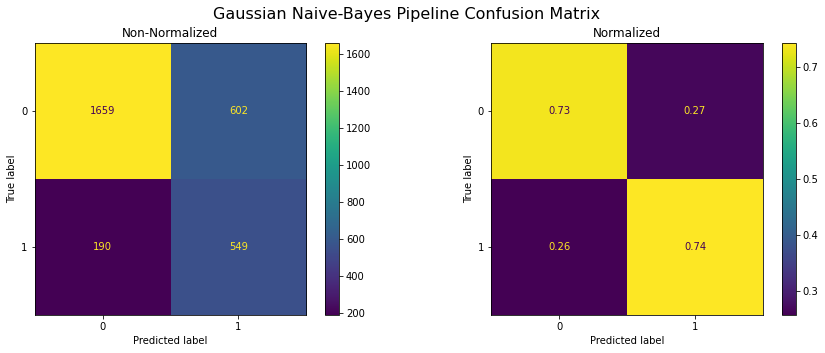

In [50]:
# Run custom function to plot confusion matrix for user-specified pipeline
plot_cm(gnb_pipeline, 'Gaussian Naive-Bayes')

In [51]:
# Plot ROC curves
# Modularize a function to reuse for subsequent pipelines
def plot_roc(pipeline, model_name):
    y_probas = pipeline.predict_proba(X_test.drop(columns='emp_id'))
    skplt.metrics.plot_roc(y_test, y_probas, figsize=(10,5))
    plt.title('{} Pipeline ROC Curves'.format(model_name), fontsize=16)

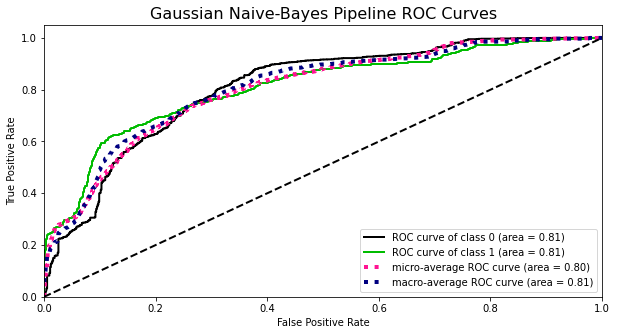

In [52]:
# Plot ROC curves
plot_roc(gnb_pipeline, 'Gaussian Naive-Bayes')

Now let's see which employees the model correctly predicted would leave.

In [53]:
# First let's modularize a function to return a dataframe of true leavers so we can reuse it for subsequent pipelines
# Don't need to set user inputs as the variables will always derive from the last pipeline that is run
def return_true_leavers():
    df = X_test.copy()
    df['y_pred'] = y_pred.tolist()
    df['y_test'] = y_test.tolist()
    true_leavers = df[['emp_id','y_pred','y_test']][(df['y_pred'] == df['y_test']) & ((df['y_pred']==1) & (df['y_test']==1))]
    true_leavers.reset_index(drop=True, inplace=True)
    return true_leavers

In [54]:
# See the list of true leavers
return_true_leavers()

emp_id  y_pred  y_test
0     14894       1       1
1       264       1       1
2      1214       1       1
3      1568       1       1
4      1418       1       1
..      ...     ...     ...
544    1635       1       1
545   12067       1       1
546     667       1       1
547    1007       1       1
548    1017       1       1

[549 rows x 3 columns]

In [55]:
# See evaluation scores
print(classification_report(y_test, y_pred),)

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      2261
           1       0.48      0.74      0.58       739

    accuracy                           0.74      3000
   macro avg       0.69      0.74      0.69      3000
weighted avg       0.79      0.74      0.75      3000



Overall the scores are not terrible but not great either. With an accuracy of only 74%, it is not likely that gridsearch hyperparamater tuning can improve this model enough. As such, we should investigate another model.

## Logistic Regression

In [56]:
# Instantiate Logistic Regression model object
lr = LogisticRegression(solver='lbfgs', max_iter=400)

In [57]:
# Build a pipeline for the feature preprocessor and model
lr_pipeline = Pipeline(steps=[('feature_preprocessor', feature_preprocessor), ('min_max_scaler', MinMaxScaler()), ('lr', lr)])

In [58]:
# Pass the pipeline into a cross validation to see how accurate it is
cross_val_score(lr_pipeline, X_train.drop(columns='emp_id'), y_train, cv=5, scoring='accuracy').mean()

0.7685638807836599

In [59]:
# Fit the training data to the pipeline
lr_pipeline.fit(X_train.drop(columns='emp_id'), y_train)

Pipeline(steps=[('feature_preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['salary']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['dept'])])),
                ('min_max_scaler', MinMaxScaler()),
                ('lr', LogisticRegression(max_iter=400))])

In [60]:
# Make prediction
y_pred = lr_pipeline.predict(X_test.drop(columns='emp_id'))
y_pred

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

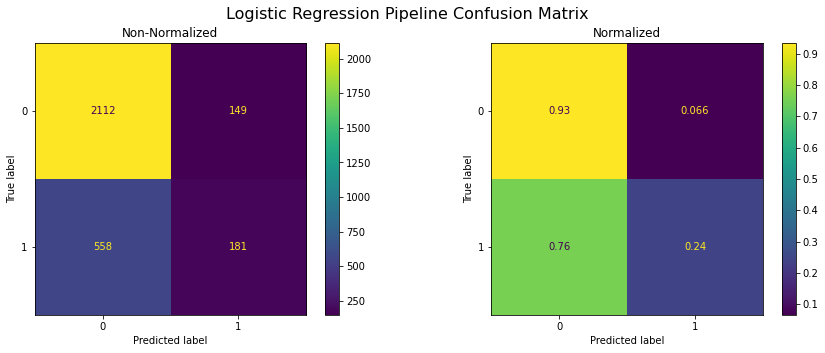

In [61]:
# Run custom function to plot confusion matrix for user-specified pipeline
plot_cm(lr_pipeline, 'Logistic Regression')

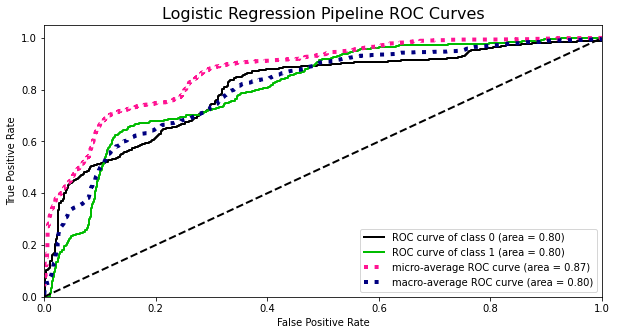

In [62]:
# Plot ROC curves
plot_roc(lr_pipeline, 'Logistic Regression')

In [63]:
# See the list of true leavers
return_true_leavers()

emp_id  y_pred  y_test
0     14894       1       1
1       264       1       1
2      1418       1       1
3       361       1       1
4     12388       1       1
..      ...     ...     ...
176    1631       1       1
177     489       1       1
178   12072       1       1
179   12185       1       1
180   14775       1       1

[181 rows x 3 columns]

In [64]:
# See evaluation scores
print(classification_report(y_test, y_pred),)

              precision    recall  f1-score   support

           0       0.79      0.93      0.86      2261
           1       0.55      0.24      0.34       739

    accuracy                           0.76      3000
   macro avg       0.67      0.59      0.60      3000
weighted avg       0.73      0.76      0.73      3000



This model is not much better than the Gaussian Naive-Bayes, so it is also unlikely that gridsearch hyperparameter tuning would help much to improve this model. We continue to investigate other models.

## K-Nearest Neighbours

In [65]:
# Instantiate K-Nearest Neighbours model object
knn = KNeighborsClassifier()

In [66]:
# Build a pipeline for the feature preprocessor and model
knn_pipeline = Pipeline(steps=[('feature_preprocessor', feature_preprocessor), ('min_max_scaler', MinMaxScaler()), ('knn', knn)])

In [67]:
# Pass the pipeline into a cross validation to see how accurate it is
cross_val_score(knn_pipeline, X_train.drop(columns='emp_id'), y_train, cv=5, scoring='accuracy').mean()

0.9379119077393356

This is a good sign and is already significantly better than the Gaussian Naive-Bayes and Logistic Regression models.

In [68]:
# Fit the training data to the pipeline
knn_pipeline.fit(X_train.drop(columns='emp_id'), y_train)

Pipeline(steps=[('feature_preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['salary']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['dept'])])),
                ('min_max_scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier())])

In [69]:
# Make prediction
y_pred = knn_pipeline.predict(X_test.drop(columns='emp_id'))
y_pred

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

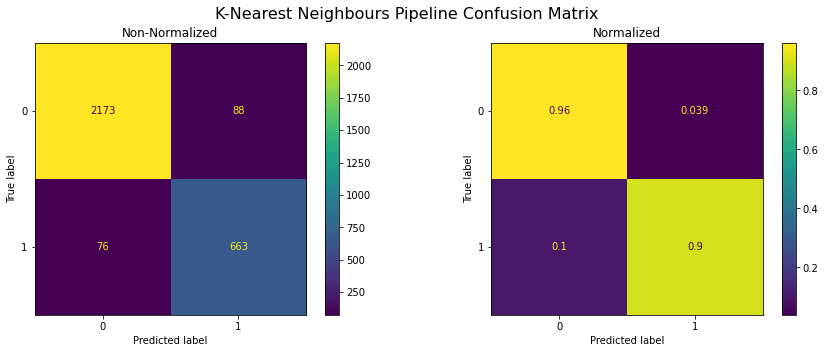

In [70]:
# Run custom function to plot confusion matrix for user-specified pipeline
plot_cm(knn_pipeline, 'K-Nearest Neighbours')

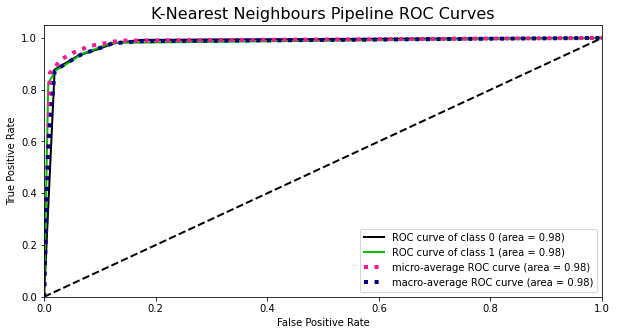

In [71]:
# Plot ROC curves
plot_roc(knn_pipeline, 'K-Nearest Neighbours')

In [72]:
# See the list of true leavers
return_true_leavers()

emp_id  y_pred  y_test
0     14894       1       1
1       264       1       1
2      1214       1       1
3       224       1       1
4      1568       1       1
..      ...     ...     ...
658    1635       1       1
659   12067       1       1
660     660       1       1
661    1007       1       1
662    1017       1       1

[663 rows x 3 columns]

In [73]:
# See evaluation scores
print(classification_report(y_test, y_pred),)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2261
           1       0.88      0.90      0.89       739

    accuracy                           0.95      3000
   macro avg       0.92      0.93      0.93      3000
weighted avg       0.95      0.95      0.95      3000



This model looks quite good already without any hyperparameter tuning! Let's investigate another model to see if we can do even better.

## Decision Tree Classifier

In [74]:
# Instantiate Decision Tree Classifier model object
dtc = DecisionTreeClassifier(class_weight='balanced')

In [75]:
# Build a pipeline for the feature preprocessor and model
dtc_pipeline = Pipeline(steps=[('feature_preprocessor', feature_preprocessor), ('min_max_scaler', MinMaxScaler()), ('dtc', dtc)])

In [76]:
# Pass the pipeline into a cross validation to see how accurate it is
cross_val_score(dtc_pipeline, X_train.drop(columns='emp_id'), y_train, cv=5, scoring='accuracy').mean()

0.9783313533416702

In [77]:
# Fit the training data to the pipeline
dtc_pipeline.fit(X_train.drop(columns='emp_id'), y_train)

Pipeline(steps=[('feature_preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['salary']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['dept'])])),
                ('min_max_scaler', MinMaxScaler()),
                ('dtc', DecisionTreeClassifier(class_weight='balanced'))])

In [78]:
# Make prediction
y_pred = dtc_pipeline.predict(X_test.drop(columns='emp_id'))
y_pred

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

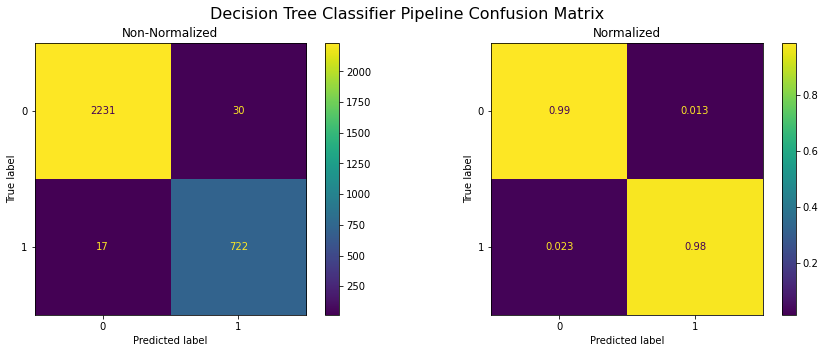

In [79]:
# Run custom function to plot confusion matrix for user-specified pipeline
plot_cm(dtc_pipeline, 'Decision Tree Classifier')

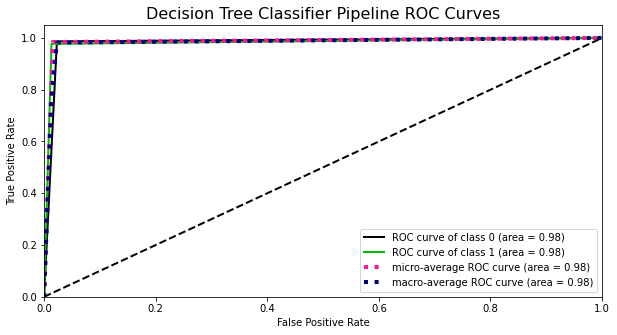

In [80]:
# Plot ROC curves
plot_roc(dtc_pipeline, 'Decision Tree Classifier')

In [81]:
# See the list of true leavers
return_true_leavers()

emp_id  y_pred  y_test
0     14894       1       1
1       264       1       1
2      1214       1       1
3     14743       1       1
4       224       1       1
..      ...     ...     ...
717    1635       1       1
718   12067       1       1
719     660       1       1
720    1007       1       1
721    1017       1       1

[722 rows x 3 columns]

In [82]:
# See evaluation scores
print(classification_report(y_test, y_pred),)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2261
           1       0.96      0.98      0.97       739

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



This model is even better than the K-Nearest Neighbours!

# Conclusion & Final Remarks

Of our models, the Decision Tree Classifer is the most accurate at 98%, followed by K-Nearest Neighbours at 95%, Logistic Regression at 76%, and Gaussian Naive-Bayes at 74%. All models were run with default parameters, and hyperparameter tuning was not pursued in this use-case as it was not deemed necessary.

For the Logistic Regression and Gaussian Naive-Bayes models, the accuracy was low enough that any improvements from hyperparameter tuning would still not yield a high enough accuracy compared to the other models which are already much more accurate with default parameters. For K-Nearest Neighbours, while already showing a high accuracy, we were able to find an even better model with the Decision Tree Classifer. As the Decision Tree Classifier is showing a near-perfect accuracy with default parameters, the trade-off for computational resources to run an exhaustive grid search for even more optimal parameters would be too costly as any performance improvement gains would be minimal given the already near-perfect accuracy.

With that said, there are some caveats to be mindful of. The dataset used has a very small feature set and is not fully representative of the feature diversity and quantity that we would see in an HRIS production environment. The dataset is very clean with no missing values which is also not representative of a production environment where incomplete and inaccurate data are day-to-day realities. As such, our models are fairly simple and have the benefit of perfect data which will inherently yield higher accuracy in general.

However, simpler models tend to outperform more complex models when there is greater data quality and quantity, and the dataset used for this project is certainly of sufficient sample size at 15,000 rows of data. As such, this warrants some confidence in our results as well.